In [1]:
# MO444-A 2s/2017 - Second assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

from __future__ import print_function
from datetime import datetime
from math import sqrt
from scipy import misc
from skimage.io import imread
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import glob
import random
import matplotlib.pyplot as plt
import numpy as np

# Some definitions
classes = np.asarray(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
int_classes = preprocessing.LabelEncoder().fit_transform(classes) # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
onehot_classes = onehot_encoder.fit_transform(int_classes.reshape(len(int_classes), 1))

def load_image_dataset(name, sample=1., as_gray=False):
    """Loads an image dataset
    name: directory in which dataset is defined
    sample: fraction of the dataset to be loaded [0, 1]
    as_gray: read images as grayscale to have a 32x32 matrix, instead of a 32x32x3 matrix in case of RGB.
    """
    random.seed(1)
    X, Y = [], []
    with open('cifar-10/%s/labels' % name) as labels:
        i = 0
        for path in sorted(glob.glob('cifar-10/%s/*.png' % name)):
            y = int(labels.next())
            if random.random() > sample:
                continue
            Y.append(y)
            X.append(imread(path, as_grey=as_gray))
    X, Y = np.array(X), np.array(Y)
    n_dim = reduce(lambda x, y: x * y, X.shape[1:])
    return X.reshape(-1, n_dim), Y

def display_image(x):
    """Prints a colored or grayscale 32x32 image"""
    colors = x.shape[0] / 32 / 32
    cmap = 'gray' if colors == 1 else 'jet'
    new_shape = (32, 32) if colors == 1 else (32, 32, colors)
    plt.imshow(x.reshape(new_shape), cmap=cmap)
    plt.show()


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:


In [2]:
# Load train dataset
data_X, data_Y = load_image_dataset('train', as_gray=True, sample=0.1)
print("Loaded %d samples" % len(data_X))

Loaded 5053 samples


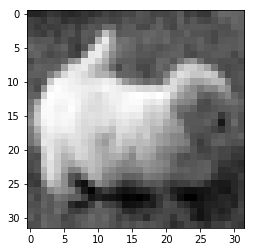

Label: dog


In [3]:
# Take a look at a sample and its class
display_image(data_X[207])

print('Label: %s' % classes[int(data_Y[207])])

In [4]:
# Implementing K-Fold to help avoiding overfitting
from sklearn.model_selection import KFold

def print_results(k, start_time, train_precision, train_recall, train_f1, 
                  validation_precision, validation_recall, validation_f1):
    print('\nk={} time elapsed: {}'.format(k, datetime.now() - start_time))
    print('           Precision  sd      Recall sd     F1 Score sd')
    print('Training:      %5.2f  ±%5.2f   %5.2f ±%5.2f    %5.2f ±%5.2f' % (
            np.mean(train_precision), np.std(train_precision), np.mean(train_recall), np.std(train_recall), np.mean(train_f1), np.std(train_f1)))
    print('Validation:    %5.2f  ±%5.2f   %5.2f ±%5.2f    %5.2f ±%5.2f' % (
            np.mean(validation_precision), np.std(validation_precision), np.mean(validation_recall), np.std(validation_recall), np.mean(validation_f1), np.std(validation_f1)))

def run_kfold(method, data_Y, data_X, scale=False, check_gradients=False, report_timeout_seconds=60):
    # prepare for 5-fold execution
    random_state = np.random.RandomState(1)
    k5_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    train_precision, train_recall, train_f1 = [], [], []
    validation_precision, validation_recall, validation_f1 = [], [], []
    start_time = last_time = datetime.now()
    k = 0
    model = None

    for train_index, validation_index in k5_fold.split(data_X):
        k += 1
        print('k%d' % k, end=' ')
        
        train_data_X, train_data_Y = data_X[train_index], data_Y[train_index]
        validation_data_X, validation_data_Y = data_X[validation_index], data_Y[validation_index]
        
        if scale:
            model_scaler = preprocessing.StandardScaler()
            train_data_X = model_scaler.fit_transform(train_data_X)
            validation_data_X = model_scaler.transform(validation_data_X)

        # Train the model(s) using the training data
        if check_gradients == True:
            if k == 4:
                model = method(train_data_X, train_data_Y, True)
            else:
                model = method(train_data_X, train_data_Y, False)
        else:
            model = method(train_data_X, train_data_Y)
        
        # Predict training data
        predicted_train_data_Y = model.predict(train_data_X)
        train_precision.append(precision_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        train_recall.append(recall_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        train_f1.append(f1_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        
        # Predict validation data
        predicted_validation_data_Y = model.predict(validation_data_X)
        validation_precision.append(precision_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        validation_recall.append(recall_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        validation_f1.append(f1_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        if (datetime.now() - last_time).total_seconds() > report_timeout_seconds:
            print_results(k, start_time, train_precision, train_recall, train_f1, validation_precision, validation_recall, validation_f1)
            
        last_time = datetime.now()
    
    print_results(k, start_time, train_precision, train_recall, train_f1, validation_precision, validation_recall, validation_f1)

    try:
        model.close()
    except AttributeError:
        pass # Nevermind...
    
    return model

In [5]:
# Create a baseline One-vs-All logistic regression model
ova_lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=100)
run_kfold(lambda X, Y: ova_lr_model.fit(X, Y), data_Y, data_X, scale=True)

k1 k2 k3 k4 k5 
k=5 time elapsed: 0:00:14.239337
           Precision  sd      Recall sd     F1 Score sd
Training:       0.68  ± 0.00    0.68 ± 0.00     0.68 ± 0.00
Validation:     0.19  ± 0.01    0.19 ± 0.01     0.19 ± 0.01


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
# Create a Multinomial (Softmax) logistic regression model
mn_lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
run_kfold(lambda X, Y: mn_lr_model.fit(X, Y), data_Y, data_X, scale=True)

k1 k2 k3 k4 k5 
k=5 time elapsed: 0:00:05.144865
           Precision  sd      Recall sd     F1 Score sd
Training:       0.62  ± 0.00    0.62 ± 0.00     0.62 ± 0.00
Validation:     0.20  ± 0.00    0.20 ± 0.00     0.20 ± 0.00


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [7]:
# Neural Networks
class NeuralNetwork(object):
    
    def __init__(self, input_size, output_size, hidden_layers=[30], learning_rate=0.5, epochs=10):
        tf.reset_default_graph() # To make sure everything is brand new.
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # input data placeholders
        self.x = tf.placeholder(tf.float32, [None, input_size], name='input')
        # output data placeholder
        self.y = tf.placeholder(tf.float32, [None, output_size], name='output')

        W = {} # hidden layers' inputs weights
        b = {} # hidden layers' bias
        Z = {} # hidden layers' neurons outputs
        a = {} # hidden layers' activation
        last_layer_size = input_size
        for i, layer_size in enumerate(hidden_layers + [output_size]):
            W[i] = tf.Variable(tf.random_normal([last_layer_size, layer_size], stddev=0.03), name='W%d'%(i+1))
            b[i] = tf.Variable(tf.random_normal([layer_size]), name='b%d'%(i+1))
            Z[i] = tf.add(tf.matmul(self.x if i == 0 else a[i-1], W[i]), b[i])
            a[i] = self.activation(Z[i])
            last_layer_size = layer_size

        self.y_pred = tf.nn.softmax(a[i])
        
        # Cost function
        y_pred_clipped = tf.clip_by_value(self.y_pred, 1e-10, 0.9999999) # To avoid log(0), returning NaN
        self.cost = -tf.reduce_mean(tf.reduce_sum(self.y * tf.log(y_pred_clipped) + (1 - self.y) * tf.log(1 - y_pred_clipped), axis=1))
        
        # Optimizer
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
        
        # Optimize directly
        self.optimization = optimizer.minimize(self.cost)
        
        # To perform gradient checking (minimize is the same as compute_gradients + apply_gradients)
        self.get_gradients = optimizer.compute_gradients(self.cost)
        self.set_gradients = optimizer.apply_gradients(self.get_gradients)
        
        # variables initializer
        self.init_op = tf.global_variables_initializer()
        
        # define a tensorflow session
        self.session = tf.Session()
        self.session.run(self.init_op)

    def activation(self, x):
        return tf.div(tf.constant(1.0), tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

    def fit(self, X, Y, check_gradients=False):
        # Apply One Hot Encoding
        Y = onehot_encoder.transform(Y.reshape(len(Y), 1))
        
        costs = []
        # Training
        for epoch in range(self.epochs):
            C = None
            if check_gradients == True and epoch == 5:
                # Perform the gradient checking and optimize
                op, grads_vars, c = self.session.run([self.set_gradients, self.get_gradients, self.cost],
                                                     feed_dict={self.x: X, self.y: Y})
                result = 0#self.numeric_grad_checking(grads_vars, X, Y)
                print("Numeric gradient check result: %f" % result)
                    
            else:
                # Perform the optimization alone (w/o gradient checking)
                op, c = self.session.run([self.optimization, self.cost], feed_dict={self.x: X, self.y: Y})
            
            #print("Epoch:", (epoch + 1), "cost: ", c)
            costs.append(c)

        self.print_costs(costs)
        return self
    
    def print_costs(self, costs):
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epoch')
        plt.show()

    def numeric_grad_checking(self, grads_vars, X, Y):
        e = 1e-4
        
        var_list = np.asarray([v for g, v in grads_vars])
        grad_list = np.asarray([g for g, v in grads_vars])
        print(var_list[0].shape)
        index = 0
        num_grad = []
        grads = []
        for var in tf.trainable_variables():
            for index_var in range(len(var_list[index])):
                for index_neuron in range(len(var_list[index][index_var])):
                    original = var_list[index][index_var][index_neuron]
    
                    var_list[index][index_var][index_neuron] = original + e
                    assign_add_op = var.assign(var_list[index])
                    self.session.run(assign_add_op)
                    cost_add = self.session.run(self.cost, feed_dict={self.x: X, self.y: Y})
                
                    var_list[index][index_var][index_neuron] = original - e
                    assign_sub_op = var.assign(var_list[index])
                    self.session.run(assign_sub_op)
                    cost_sub = self.session.run(self.cost, feed_dict={self.x: X, self.y: Y})
                    
                    curr_cost = (cost_add - cost_sub) / (2 * e)
                
                    print("index: %s, index_var: %s, index_neuron: %s" % (index, index_var, index_neuron))
                    print("cost: %f, grad: %f" % (curr_cost, grad_list[index][index_var][index_neuron]))

                    num_grad.append(curr_cost)
                    grads.append(grad_list[index][index_var][index_neuron])
                
                    # Restore original values
                    var_list[index][index_var][index_neuron] = original
                    assign_orig_op = var.assign(var_list[index])
                    self.session.run(assign_orig_op)
                
            # increase index
            index += 1
        
        num_grad_arr = np.asarray(num_grad)
        grads_arr = np.asarray(grads)
        
        return norm(grads_arr - num_grad_arr) / norm(grads_arr + num_grad_arr)
        
    def predict(self, X):
        # Forward propagation
        prediction = self.session.run(self.y_pred, feed_dict={self.x: X})
        return np.argmax(prediction, 1)
    
    def close(self):
        self.session.close()


k1 

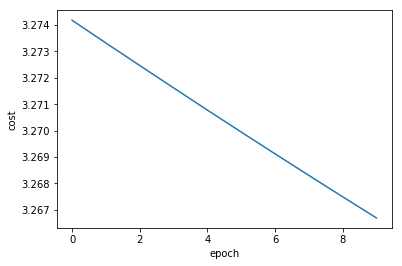

/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


k2 

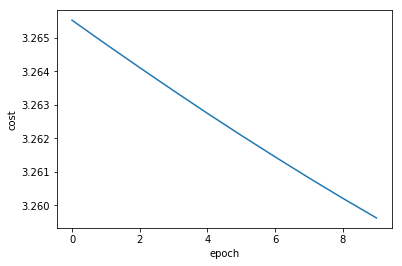

k3 

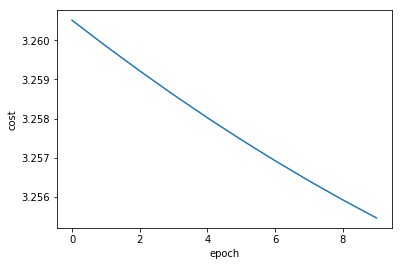

k4 Numeric gradient check result: 0.000000


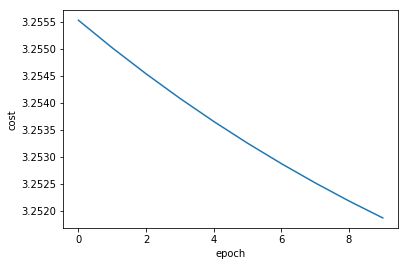

k5 

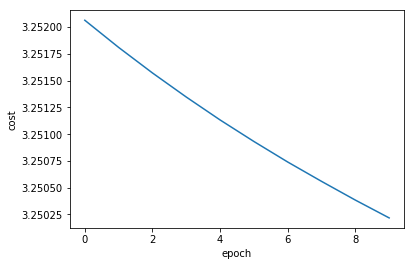


k=5 time elapsed: 0:00:02.363459
           Precision  sd      Recall sd     F1 Score sd
Training:       0.01  ± 0.00    0.10 ± 0.00     0.02 ± 0.00
Validation:     0.01  ± 0.00    0.10 ± 0.01     0.02 ± 0.00


In [8]:
# Neural Network with a single hidden layer
nn_single_hl_model = NeuralNetwork(input_size=len(data_X[0]), output_size=len(classes))
run_kfold(lambda X, Y, check_gradients: nn_single_hl_model.fit(X, Y, check_gradients), data_Y, data_X, check_gradients=True)

k1 

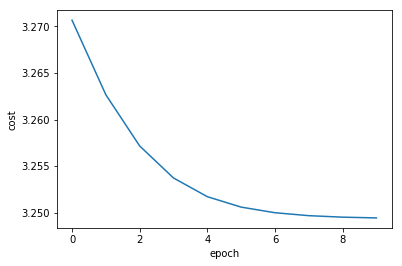

k2 

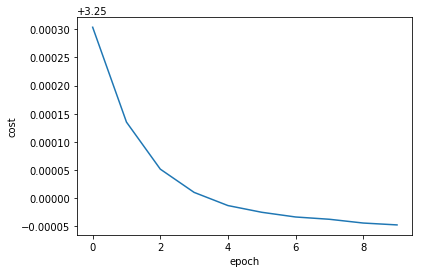

k3 

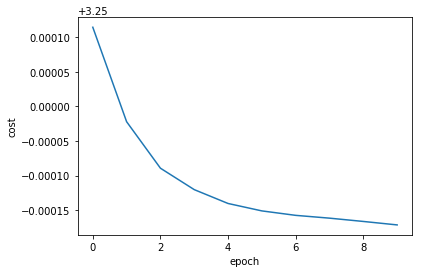

k4 

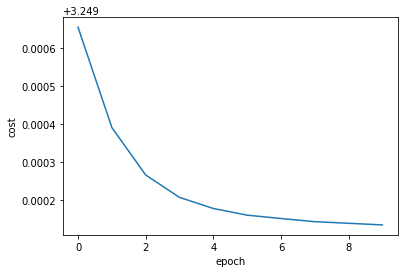

k5 

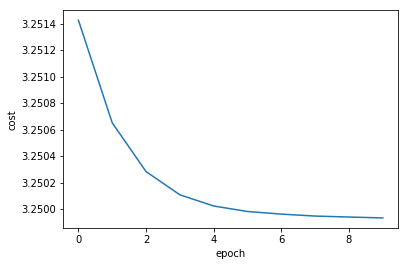


k=5 time elapsed: 0:00:09.246404
           Precision  sd      Recall sd     F1 Score sd
Training:       0.02  ± 0.01    0.11 ± 0.00     0.03 ± 0.01
Validation:     0.02  ± 0.01    0.10 ± 0.01     0.02 ± 0.01


In [9]:
# Neural Network with two hidden layers
nn_two_hl_model = NeuralNetwork(input_size=len(data_X[0]), output_size=len(classes), hidden_layers=[300, 300])
run_kfold(lambda X, Y: nn_two_hl_model.fit(X, Y), data_Y, data_X)